In [1]:
import os
import pandas as pd
import numpy as np
import time

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
df_structures_idx = df_structures.set_index('molecule_name')
df_train_idx = df_train.set_index('molecule_name')

In [5]:
def assign_atoms_index(df_idx, molecule):
    se_0 = df_idx.loc[molecule]['atom_index_0']
    se_1 = df_idx.loc[molecule]['atom_index_1']
    if type(se_0) == np.int64:
        se_0 = pd.Series(se_0)
    if type(se_1) == np.int64:
        se_1 = pd.Series(se_1)
    assign_idx = pd.concat([se_0, se_1]).unique()
    assign_idx.sort()
    return assign_idx

In [6]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = ((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

In [35]:
def gen_df_num_bond(df_structures_idx, mol):

    dist_mat = get_dist_matrix(df_structures_idx, mol)
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]

    non_h_idx = df_temp[df_temp['atom'] != 'H']['atom_index'].values
    non_h = df_temp[df_temp['atom'] != 'H']['atom'].values

    df_non_h_dist = dist_mat[non_h_idx][:, non_h_idx]
    num_bond_list = []
    for i, idx in enumerate(non_h_idx):
        num_bond_list.append(sum((df_non_h_dist[i] > 0) * (df_non_h_dist[i] < 3)))
    num_non_h_bond = np.array(num_bond_list)

    h_idx = df_temp[df_temp['atom'] == 'H']['atom_index'].values
    h_dist_mat = dist_mat[h_idx]
    h_con_idx = h_dist_mat.argsort()[:,1]

    num_h_bond = np.zeros(num_atoms)
    for i in h_con_idx:
        num_h_bond[idx] += 1

    num_bond_non_h = num_non_h_bond + num_h_bond[non_h_idx]
    num_bond = np.ones(num_atoms)
    num_bond[non_h_idx] = num_bond_non_h

    se_num_bond = pd.Series(num_bond, name='num_bonds', dtype='int')
    se_num_bond = se_num_bond.where(se_num_bond < 5, 4)
    se_atom = pd.Series(df_temp['atom'].values, name='atom')
    se_atom_idx = pd.Series(df_temp['atom_index'].values, name='atom_index')

    df_bond = pd.concat([se_atom, se_atom_idx, se_num_bond], axis=1)
    df_bond['molecule_name'] = mol
    return df_bond 

In [36]:
mol = 'dsgdb9nsd_000201'
gen_df_num_bond(df_structures_idx, mol)

0     1
1     3
2     2
3     2
4     2
5     9
6     1
7     1
8     1
9     1
10    1
11    1
12    1
Name: num_bonds, dtype: int32


,atom,atom_index,num_bonds,molecule_name
0,C,0,1,dsgdb9nsd_000201
1,C,1,3,dsgdb9nsd_000201
2,C,2,2,dsgdb9nsd_000201
3,N,3,2,dsgdb9nsd_000201
4,C,4,2,dsgdb9nsd_000201
5,C,5,4,dsgdb9nsd_000201
6,H,6,1,dsgdb9nsd_000201
7,H,7,1,dsgdb9nsd_000201
8,H,8,1,dsgdb9nsd_000201
9,H,9,1,dsgdb9nsd_000201


In [20]:
se = gen_df_num_bond(df_structures_idx, mol)['num_bonds']
se.where(se < 4, 4)

0     1
1     3
2     2
3     2
4     2
5     4
6     1
7     1
8     1
9     1
10    1
11    1
12    1
Name: num_bonds, dtype: int32

In [16]:
df_train_idx.loc[mol]

,id,atom_index_0,atom_index_1,type,scalar_coupling_constant
molecule_name,,,,,
dsgdb9nsd_000201,3650,6,0,1JHC,85.842000
dsgdb9nsd_000201,3651,6,1,2JHC,-4.718360
dsgdb9nsd_000201,3652,6,2,3JHC,4.936420
dsgdb9nsd_000201,3653,6,5,3JHC,1.861110
dsgdb9nsd_000201,3654,6,7,2JHH,-12.246600
dsgdb9nsd_000201,3655,6,8,2JHH,-14.159400
dsgdb9nsd_000201,3656,7,0,1JHC,84.846400
dsgdb9nsd_000201,3657,7,1,2JHC,-4.131010
dsgdb9nsd_000201,3658,7,2,3JHC,6.425840


In [8]:
def get_pickup_dist_matrix(df_idx, df_structures_idx, molecule, num_pickup=5, atoms=['H', 'C', 'N', 'O', 'F']):
    pickup_dist_matrix = np.zeros([0, len(atoms)*num_pickup*2])
    assigned_idxs = assign_atoms_index(df_idx, molecule) # [0, 1, 2, 3, 4, 5, 6] -> [1, 2, 3, 4, 5, 6]
    dist_mat = get_dist_matrix(df_structures_idx, molecule)
    df_bond = gen_df_num_bond(df_structures_idx, molecule)
    num_bonds = df_bond['num_bonds'].values
    for idx in assigned_idxs: # [1, 2, 3, 4, 5, 6] -> [2]
        df_temp = df_structures_idx.loc[molecule]
        locs = df_temp[['x','y','z']].values

        dist_arr = dist_mat[idx] # (7, 7) -> (7, )

        atoms_mole = df_structures_idx.loc[molecule]['atom'].values # ['O', 'C', 'C', 'N', 'H', 'H', 'H']
        atoms_mole_idx = df_structures_idx.loc[molecule]['atom_index'].values # [0, 1, 2, 3, 4, 5, 6]

        mask_atoms_mole_idx = atoms_mole_idx != idx # [ True,  True, False,  True,  True,  True,  True]
        masked_atoms = atoms_mole[mask_atoms_mole_idx] # ['O', 'C', 'N', 'H', 'H', 'H']
        masked_atoms_idx = atoms_mole_idx[mask_atoms_mole_idx]  # [0, 1, 3, 4, 5, 6]
        masked_dist_arr = dist_arr[mask_atoms_mole_idx]  # [ 5.48387003, 2.15181049, 1.33269675, 10.0578779, 4.34733927, 4.34727838]
        masked_locs = locs[masked_atoms_idx]
        masked_num_bonds = num_bonds[masked_atoms_idx]

        sorting_idx = np.argsort(masked_dist_arr) # [2, 1, 5, 4, 0, 3]
        sorted_atoms_idx = masked_atoms_idx[sorting_idx] # [3, 1, 6, 5, 0, 4]
        sorted_atoms = masked_atoms[sorting_idx] # ['N', 'C', 'H', 'H', 'O', 'H']
        sorted_dist_arr = 1/masked_dist_arr[sorting_idx] #[0.75035825,0.46472494,0.23002898,0.23002576,0.18235297,0.09942455]
        sorted_num_bonds = masked_num_bonds[sorting_idx]

        target_matrix = np.zeros([len(atoms), num_pickup*2])
        for a, atom in enumerate(atoms):
            pickup_atom = sorted_atoms == atom # [False, False,  True,  True, False,  True]
            pickup_dist = sorted_dist_arr[pickup_atom] # [0.23002898, 0.23002576, 0.09942455]
            pickup_num_bond = sorted_num_bonds[pickup_atom]

            num_atom = len(pickup_dist)
            if num_atom > num_pickup:
                target_matrix[a, :num_pickup] = pickup_dist[:num_pickup]
                target_matrix[a, num_pickup:] = pickup_num_bond[:num_pickup]
            else:
                target_matrix[a, :num_atom] = pickup_dist
                target_matrix[a, num_pickup:num_pickup+num_atom] = pickup_num_bond
        
        pickup_dist_matrix = np.vstack([pickup_dist_matrix, target_matrix.reshape(-1)])
    return pickup_dist_matrix #(num_atoms, num_pickup*5)

In [10]:
num = 5
mols = df_train['molecule_name'].unique()
num_div = len(mols) // 3
dist_mat = np.zeros([0, num*5*2])
atoms_idx = np.zeros([0], dtype=np.int32)
molecule_names = np.empty([0])

start = time.time()

for mol in mols[60000:70000]:
    
    assigned_idxs = assign_atoms_index(df_train_idx, mol)
    dist_mat_mole = get_pickup_dist_matrix(df_train_idx, df_structures_idx, mol, num_pickup=num)
    mol_name_arr = [mol] * len(assigned_idxs) 
    
    molecule_names = np.hstack([molecule_names, mol_name_arr])
    atoms_idx = np.hstack([atoms_idx, assigned_idxs])
    dist_mat = np.vstack([dist_mat, dist_mat_mole])
    
col_name_list = []
atoms = ['H', 'C', 'N', 'O', 'F']
for a in atoms:
    for n in range(num):
        col_name_list.append('dist_{}_{}'.format(a, n))
    for n in range(num):
        col_name_list.append('num_bond_{}_{}'.format(a, n))
        
se_mole = pd.Series(molecule_names, name='molecule_name')
se_atom_idx = pd.Series(atoms_idx, name='atom_index')
df_dist = pd.DataFrame(dist_mat, columns=col_name_list)
df_distance = pd.concat([se_mole, se_atom_idx,df_dist], axis=1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:706.4417717456818[sec]


In [11]:
df_distance.shape

(181966, 52)

In [12]:
df_distance.to_csv(OUTPUT + '20190618_dist_bond_train_temp.csv', index=False)

In [4]:
# df_distance_list = []
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp0.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp1.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp2.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp3.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp4.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp5.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp6.csv'))

# df_distance = pd.concat(df_distance_list, axis=0)
# df_distance.shape

(1405126, 52)

In [5]:
def merge_atom(df, df_distance):
    df_merge_0 = pd.merge(df, df_distance, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'])
    df_merge_0_1 = pd.merge(df_merge_0, df_distance, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'])
    del df_merge_0_1['atom_index_x'], df_merge_0_1['atom_index_y']
    return df_merge_0_1

In [8]:
start = time.time()
df_train_dist = merge_atom(df_train, df_distance)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:33.48328757286072[sec]


In [9]:
df_train_dist.to_csv(OUTPUT + '20190618_dist_bond_train.csv', index=False)

In [9]:
df_train_dist = pd.read_csv(OUTPUT + '20190618_dist_bond_train.csv')

In [23]:
import matplotlib.pyplot as plt

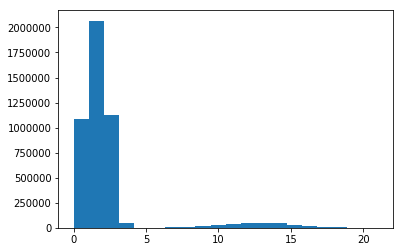

In [25]:
plt.hist(df_train_dist['num_bond_C_0_x'], bins=20)
plt.show()

In [40]:
df_train_dist['num_bond_C_0_x'].value_counts()

2.0    2067097
3.0    1127063
1.0    1087409
4.0     376571
0.0          7
Name: num_bond_C_0_x, dtype: int64

In [39]:
for i in range(5):
    temp = df_train_dist['num_bond_C_{}_x'.format(i)]
    temp = temp.where(temp < 5, 4)
    df_train_dist['num_bond_C_{}_x'.format(i)] = temp

In [41]:
df_train_dist['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64